# Assignment1: Prototypical Networks


<center><img src="https://raw.githubusercontent.com/oscarknagg/few-shot/master/assets/proto_nets_diagram.png"/></center>

> Figure 1: Prototypical networks in a nutshell. In a 3-way 5-shot classification task, the class
prototypes c1, c2, c3 are computed from each class’s support features (colored circles). The
prototypes define decision boundaries based on Euclidean distance. A query example $x$
is determined to be class 2 since its features (white circle) lie within that class’s decision
region.


In this assignment, let's use [**prototypical networks**](https://papers.nips.cc/paper/2017/hash/cb8da6767461f2812ae4290eac7cbc42-Abstract.html) to solve the *n-way k-shot few-shot learning* problem with the [Omniglot](https://www.tensorflow.org/datasets/catalog/omniglot) dataset. 

- **IMPORTANT**: 과제 제출하실 때 레포트를 pdf로 변환하고, `Assignment.ipynb`, `dataloader.py`, `model.py`, `train.py`, 모두 압축해서 **이름_학번_Assignment1.zip** 형식으로 ETL에 올리시길 바랍니다.
- Assignment 1 is due 23:59 PM 4/14. Note that 10%p of your score will be deducted for every hour you are late.
- Make sure you are using the latest version of [TensorFlow](https://www.tensorflow.org/api_docs/python/tf), or at least the 2.3 version.
- *If you have any questions regarding the assignment, please contact me at steve2972@snu.ac.kr*

---

## Problem 1

We define a **task** to be an *n-way k-shot* image classification problem. The maximum number of tasks that can be created from a dataset can be defined as $M \choose N$ $\cdot$ $ K \choose k$ where $M$=the number of classes in the dataset, $N$=the number of classes in a task, $K$=the total number of images in a class, and $k$=the number of shots in a class. In this problem, we define a method to create an upper bound to the number of tasks used during training. 

**Problem**: In the `dataloader.py` file, complete the implementation of the `DataLoader.generate_task_list` method and the `DataLoader.data_generator` method. Details concerning the implementation are as follows:

- The `generate_task_list` method generates a **list of dictionaries** where each dictionary comprises a **task** in the form of `{class_name: [random sequence of image indexes]}`
    - For example, a 2-way 5-shot task for both the support & query datasets can be generated as `{'A': [1,3,5,7,9,2,4,6,8, 10], 'B': [8,6,4,10,2,1,5,3,7,9]}`
    - Note that the length of the random sequence of image indexes should equal the # of shots in the support dataset $+$ # of shots in the query dataset.
    
- The `data_generator` method generates a **support** and a **query dataset** where each dataset is in the form of a numpy array with shape `[num_way, num_shot, image_width, image_height, num_channels]`.
    - Note that `data_generator` is created based on tasks which have the form `{class_name: [random sequence of image indexes]}`
    
If the `dataloader.py` file is implemented correctly, the following code should run without error.

In [1]:
from dataloader import DataLoader

num_ways = 5
support_shots = 5
query_shots = 5

train_dataset = DataLoader('train', n_way=num_ways, n_support=support_shots, n_query=query_shots)
val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=query_shots)

Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing


---

**If implemented correctly, we can also visualize a random task using the `visualize_random_task` method.**

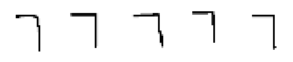

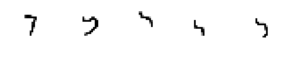

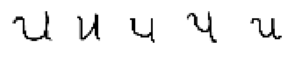

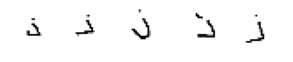

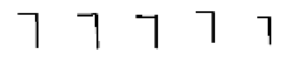

In [2]:
train_dataset.visualize_random_task()

## Problem 2

Next we will implement the prototypical network and examine how the performance of the model changes when **the total number of tasks is changed from 1k to 10k**.

As discussed in the lecture, the basic idea of protonets is to learn a mapping $f_\theta(\cdot)$ from images to features such that images of the same class are close to each other in a feature space. Central to this is the notion of a *prototype*

$$c_n = \frac{1}{K} \sum_{(x,y)\in\mathcal{D}^{tr}_i:y=n} f_\theta(x)$$

i.e. for task $i$, the prototype of the $n$-th class $c_n$ is defined as the mean of the $K$ feature
vectors of that class’s support images. To classify some image $x$, we compute a measure of
distance $d$ between $f_\theta(x)$ and each of the prototypes. We will use the squared Euclidean
distance:

$$d(f_\theta(x),c_n) = ||f_\theta(x) - c_n ||^2_2$$

We interpret the negative squared distances as **logits**, or *unnormalized log-probabilities,
of* $x$ *belonging to each class*. To obtain the proper probabilities, we apply the softmax
operation:

$$p_\theta(y = n|x) = \frac{\exp(-d(f_\theta(x),c_n))}{\sum^N_{n'=1}\exp(-d(f_\theta(x),c_{n'}))}$$

Because the softmax operation preserves ordering, the class whose prototype is closest to
$f_\theta(x)$ is naturally interpreted as the most likely class for $x$. To train the model to generalize,
we compute prototypes using support data, but minimize the negative log likelihood of the query data

$$\mathcal{J}(\theta) = \mathbb{E}_{\mathcal{T}\sim p(\mathcal{T}), (\mathcal{D}^{tr}, \mathcal{D}^{ts})\sim \mathcal{T}} \left[ \frac{1}{NQ} \sum_{(x^{ts},y^{ts})\sim\mathcal{D}^{ts}} -\log p_\theta(y=y^{ts} | x^{ts})\right]$$

Notice that this is equivalent to using a cross-entropy loss.

We optimize $\theta$ using Adam, and as is standard for stochastic gradient methods, we approximate the objective for $\mathcal{J}$ with
Monte Carlo estimation on minibatches of tasks. Thus, for one minibatch of size $B$, we have

$$\mathcal{J}(\theta) \approx \frac{1}{B}\sum_{i=1}^B \left[ \frac{1}{NQ} \sum_{(x^{ts},y^{ts})\sim\mathcal{D}^{ts}} -\log p_\theta(y=y^{ts} | x^{ts})\right]$$


**Problem:**

1. In the `model.py` file, complete the implementation of the `Prototypical_Network.call` method. Pay attention to the inline comments.
2. Test the model with different amounts of training tasks (e.g. from 1k to 10k).
    1.  Create a plot of the validation accuracy using `matplotlib` and report your findings. 
        - Train and validate the model on 5-way 5-shot tasks for both the support and query datasets.
        - [Hint]: you should obtain a query accuracy on the validation split of **at least** 97% with 10k tasks.
    2. Also plot how the degree of overfitting (the difference between training accuracy and validation accuracy) changes with different amounts of tasks.
3. Repeat (2) with different tasks [5way-1shot, 20way-5shot, 20way-1shot] and report your findings


In [3]:
# import train

# num_tasks = 10000 # The total number of tasks in the predefined task distribution
# num_epochs = 100 # The number of epochs to train the model
# num_tasks_per_epoch = 100 # The number of tasks to be trained on for each epoch

# # metrics = [train accuracies, train losses, validation accuracies, validation losses]
# metrics = train.train_model(train_dataset, val_dataset, 
#                             n_tasks=num_tasks, n_epochs=num_epochs, 
#                             n_tpe=num_tasks_per_epoch)

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from collections import defaultdict
import train

def save_exp_results(results, file_path):
    with Path(file_path).open('wb') as file:
        pickle.dump(results, file)

def load_exp_results(file_path):
    with Path(file_path).open('rb') as file:
        results = pickle.load(file)
    return results

## 2.1 

In [5]:
# 2.1 - 5-way 5-shot tasks
n_tasks_list = [100, 1000, 10000]
num_epochs = 100
num_tasks_per_epoch = 20

num_ways = 5
support_shots = 5
query_shots = 5

train_dataset = DataLoader('train', n_way=num_ways, n_support=support_shots, n_query=query_shots)
val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=query_shots)

results = defaultdict()
for num_tasks in n_tasks_list:
    metrics = train.train_model(train_dataset, val_dataset, 
                            n_tasks=num_tasks, n_epochs=num_epochs, 
                            n_tpe=num_tasks_per_epoch)
    results[num_tasks] = metrics
save_exp_results(results, file_path='result_5way-5shot.pickle') 

Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing


Training Epoch: 100: 100%|██████████| 20/20 [00:00<00:00, 29.21it/s, Train Loss:0.055 | Train Acc:98.80% | Val Loss:0.046 | Val Acc:98.20%]



* 5 way - 5 shot (5 query shots, 5 support shots)
* number of training epochs: 100
* number tasks per epochs: 20

Given 100 number of training tasks, the training accuracy and loss converge faster than others. But it get overfitted after about 30 training epoch and achieves about 90% of the validation accuracy. 

However, in 1k and 10k settings the validation accuracy achieved to 95% on average, better than 100 training tasks. The performance are similar between 1k and 10k settings.

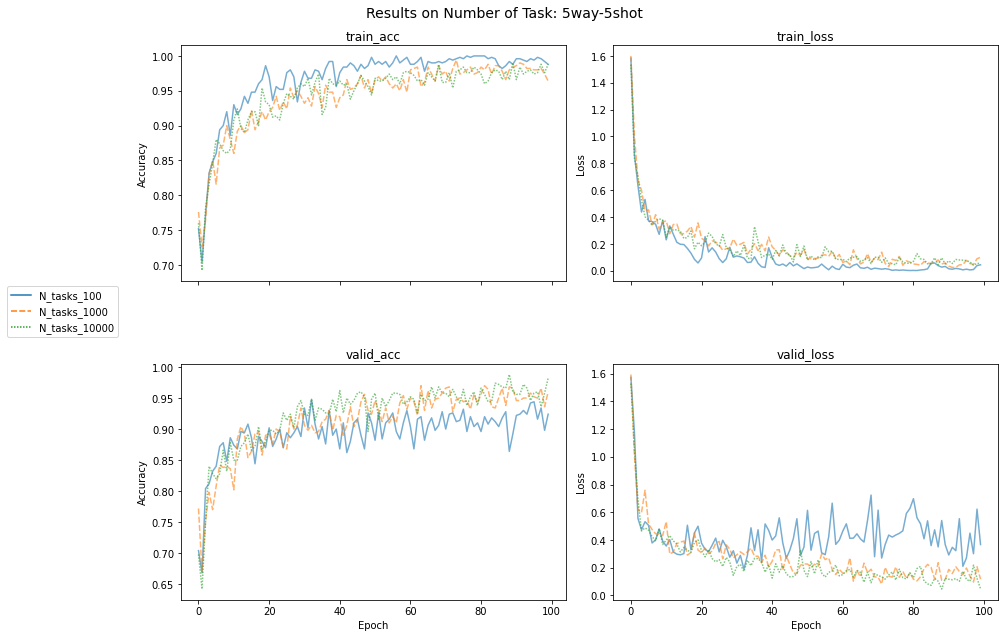

In [17]:
n_tasks_list = [100, 1000, 10000]
results = load_exp_results(file_path='result_5way-5shot.pickle') 

fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharex=True, sharey=False)

for i, title in enumerate(['train_acc', 'train_loss', 'valid_acc', 'valid_loss']):
    ax = axes.flatten()[i]
    df = pd.DataFrame(list(zip(*[results[t][i] for t in n_tasks_list])), columns=list(map(lambda x: f'N_tasks_{x}', n_tasks_list)))
    legend = 'auto' if i == 0 else False
    sns.lineplot(data=df, alpha=0.6, legend=legend, ax=ax)
    ax.set_title(f'{title}', size=12)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss' if 'loss' in title else 'Accuracy')
    if i == 0:
        ax.legend(bbox_to_anchor=(-0.15, 0.0))

fig.suptitle('Results on Number of Task: 5way-5shot', fontsize=14)
plt.tight_layout()
plt.show()
fig.savefig('2-1.png')

## 2.2

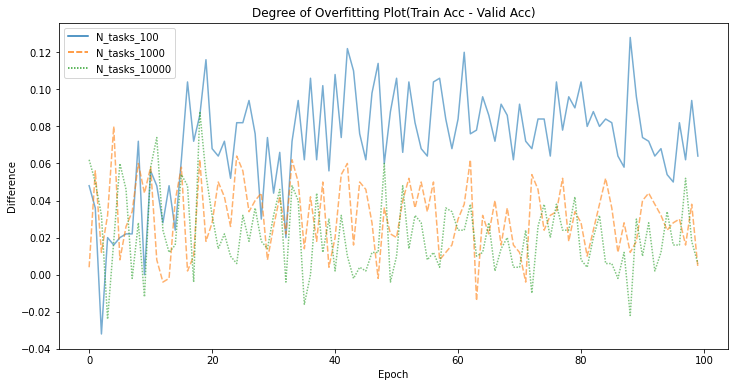

In [18]:
# degree of overfitting plot
df_train = pd.DataFrame(list(zip(*[results[t][0] for t in n_tasks_list])), columns=list(map(lambda x: f'N_tasks_{x}', n_tasks_list)))
df_valid = pd.DataFrame(list(zip(*[results[t][2] for t in n_tasks_list])), columns=list(map(lambda x: f'N_tasks_{x}', n_tasks_list)))
df = df_train - df_valid
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(data=df, alpha=0.6, ax=ax)
ax.set_title('Degree of Overfitting Plot(Train Acc - Valid Acc)', fontsize=12)
ax.set_xlabel('Epoch')
ax.set_ylabel('Difference')
plt.show()
fig.savefig('2-2.png')

## 3.

In [9]:
# 3. - [5way-1shot, 20way-5shot, 20way-1shot]
n_tasks_list = [100, 1000, 10000]
num_epochs = 100
num_tasks_per_epoch = 20

n_ways_list = [5, 20, 20]
n_shots_list = [1, 5, 1]

support_shots = 5

for num_ways, num_shots in zip(n_ways_list, n_shots_list):
    training_typ = f'{num_ways}way-{num_shots}shot'
    print(f'Training {training_typ}')
    results = defaultdict()
    train_dataset = DataLoader('train', n_way=num_ways, n_support=support_shots, n_query=num_shots)
    val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=num_shots)
    for num_tasks in n_tasks_list:
        metrics = train.train_model(train_dataset, val_dataset, 
                                n_tasks=num_tasks, n_epochs=num_epochs, 
                                n_tpe=num_tasks_per_epoch)
        results[num_tasks] = metrics
    save_exp_results(results, file_path=f'result_{num_ways}-way{num_shots}shot.pickle') 

Training 5way-1shot
Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing


Training Epoch: 100: 100%|██████████| 20/20 [00:00<00:00, 35.90it/s, Train Loss:0.162 | Train Acc:97.00% | Val Loss:0.181 | Val Acc:94.00%]


Training 20way-5shot
Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing


Training Epoch: 100: 100%|██████████| 20/20 [00:02<00:00,  8.45it/s, Train Loss:0.081 | Train Acc:97.60% | Val Loss:0.187 | Val Acc:95.40%]


Training 20way-1shot
Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing


Training Epoch: 100: 100%|██████████| 20/20 [00:01<00:00, 13.48it/s, Train Loss:0.092 | Train Acc:96.25% | Val Loss:0.270 | Val Acc:92.50%]


* number of training epochs: 100
* number tasks per epochs: 20

Comparing with various tasks, 
- In 100 number of tasks, it is easily overfitted at the early epoches in the all combinations of tasks except the 5 way-5 shots tasks. Also, there are about 20% between 5 shots and 1shots. Since the 20way tasks are more difficult than 5 way, the validation accuracy of 20way tasks are lower than 5 way. 
- In 1000 number of tasks, 5way tasks are not overfitted, but 20way tasks are overfitted at about 20 epochs. Also, there are about 5%(5way) / 10%(20way) gap between 5 shots and 1 shot at in the validation accuracy. 1 shot tasks are lower than 5 shots tasks. This is because the 1 shot task is more difficult than 5 shot.
- In 1000 number of tasks, the gap between tasks are much lower than 1000 number of tasks case, but still have like 10% gaps between 5 shots and 1 shot in the validation accuracy.

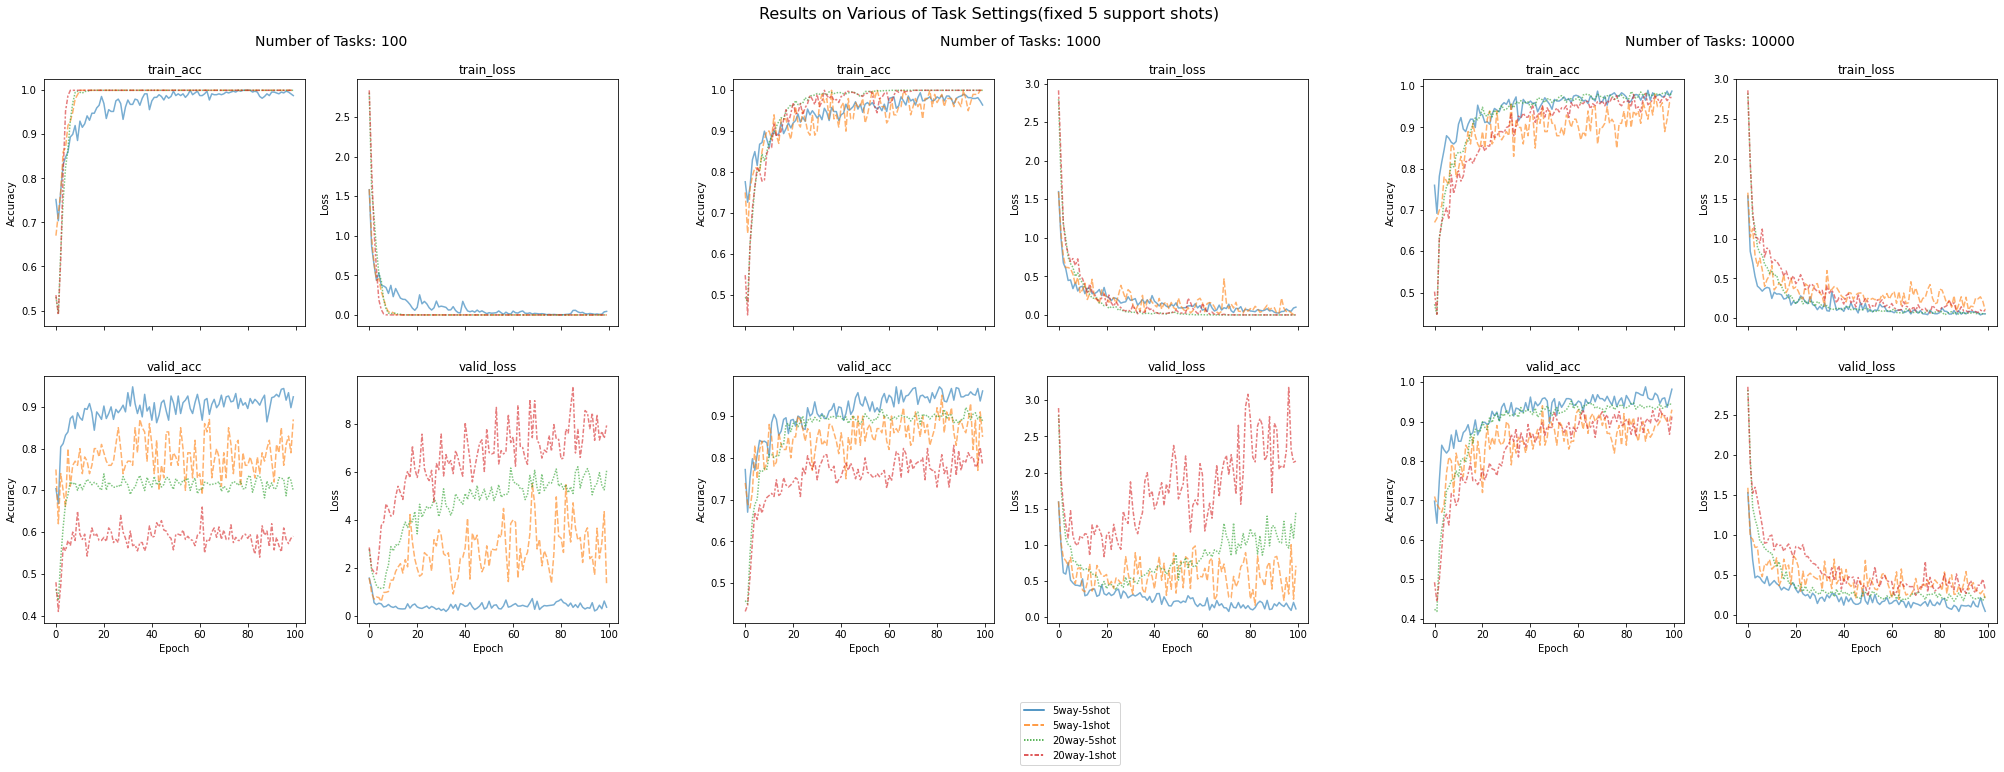

In [21]:
fig = plt.figure(figsize = (35, 10))
outer_gs = fig.add_gridspec(1, 3, wspace=0.2, hspace=0)

n_tasks_list = [100, 1000, 10000]
exps = ['5way-5shot', '5way-1shot', '20way-5shot', '20way-1shot']

all_res = defaultdict()
for e in exps:
    all_res[e] = load_exp_results(file_path=f'result_{e}.pickle') 
title_axes = outer_gs.subplots()
    
for i, n_task in enumerate(n_tasks_list):
    title_ax = title_axes[i]
    title_ax.axis('off')
    title_ax.set_title(f'Number of Tasks: {n_task}', y=1.05, fontsize=14)

    inner_gs = outer_gs[0, i].subgridspec(2, 2)    
    axes = inner_gs.subplots(sharex=True)
    for k, title in enumerate(['train_acc', 'train_loss', 'valid_acc', 'valid_loss']):
        ax = axes.flatten()[k]
        df = pd.DataFrame(list(zip(*[all_res[e][n_task][k] for e in exps])), columns=exps)
        legend = 'auto' if (i == 1) and (k == 0) else False
        sns.lineplot(data=df, alpha=0.6, legend=legend, ax=ax)
        ax.set_title(f'{title}', size=12)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss' if 'loss' in title else 'Accuracy')
        if (i == 1) and (k == 0):
            lgd = ax.legend(bbox_to_anchor=(1.5, -1.5))
fig.suptitle('Results on Various of Task Settings(fixed 5 support shots)', fontsize=16)
plt.show()
fig.savefig('2-3.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

## Problem 3

Finally, we will evaluate the generalization performance of the model by using a **different test setting from a training setting**.

<br>

As prototypical networks are based on a nonparametric method, we can flexibly train the model with different types of tasks (e.g. 5way1shot tasks + 5way5shot tasks). Let's assume we are allowed to use up to 30 training samples to train a single task. Evaluate the performance of the model when we train the model using **randomly defined training tasks**.



**Problem**:

1. In the `dataloader.py` file, implement the `random_data_generator` method.
2. Using the experimental details outlined below, run experiments and compare with the results from Problem 2
    - Note that you do not need to specify a set number of tasks for this problem


**Experimental Details**:
- *Train setting*: Assume to use exactly 30 images for each task (for support + query). First randomly select $N$ from the set $\{2, 3, 5, 6, 10, 15\}$. This means that each $N$ can use $\{15, 10, 6, 5, 3, 2\}$ samples per class respectively. By properly splitting the number of samples into 2 splits (support/query), we can randomly define different tasks.
    - For example, an example support/query task can be defined as support={5-way 4-shot}, and query={5-way 2-shot}.
    - *Extra Credit (optional)*: implement and test a method where we use a flexible number of images (not limited to just 30) where $N$ can also be defined randomly.
- *Test setting*: 5way 5 shot (5 $\cdot$ 5 for support + 5 $\cdot$ 1 for query = 30 images)


In [14]:
# num_ways = 5
# support_shots = 5
# query_shots = 1

# train_dataset = DataLoader('train')
# val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=query_shots)

# num_epochs = 100 # The number of epochs to train the model
# num_tasks_per_epoch = 20 # The number of tasks to be trained on for each epoch
# num_tasks = 1000
# # metrics = [train accuracies, train losses, validation accuracies, validation losses]
# metrics = train.train_model(train_dataset, val_dataset, 
#                             n_tasks=num_tasks, n_epochs=num_epochs, 
#                             n_tpe=num_tasks_per_epoch, is_random=True)

In [15]:
n_tasks_list = [100, 1000, 10000]
num_epochs = 100
num_tasks_per_epoch = 20

num_ways = 5
support_shots = 5
query_shots = 1

train_dataset = DataLoader('train')
val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=query_shots)

results = defaultdict()
for num_tasks in n_tasks_list:
    metrics = train.train_model(train_dataset, val_dataset, 
                            n_tasks=num_tasks, n_epochs=num_epochs, 
                            n_tpe=num_tasks_per_epoch, is_random=True)
    results[num_tasks] = metrics
save_exp_results(results, file_path='result_random_tasks.pickle') 

Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing


Training Epoch: 100: 100%|██████████| 20/20 [00:00<00:00, 29.04it/s, Train Loss:0.147 | Train Acc:96.25% | Val Loss:0.084 | Val Acc:99.00%]


Comparing the results in 2, the random tasks converge more slower and has no overfitting in tall number of tasks settings. There might be a regularization effect by training with random tasks. So, we can use even a smaller number of tasks to achieve the validation accuracy. 

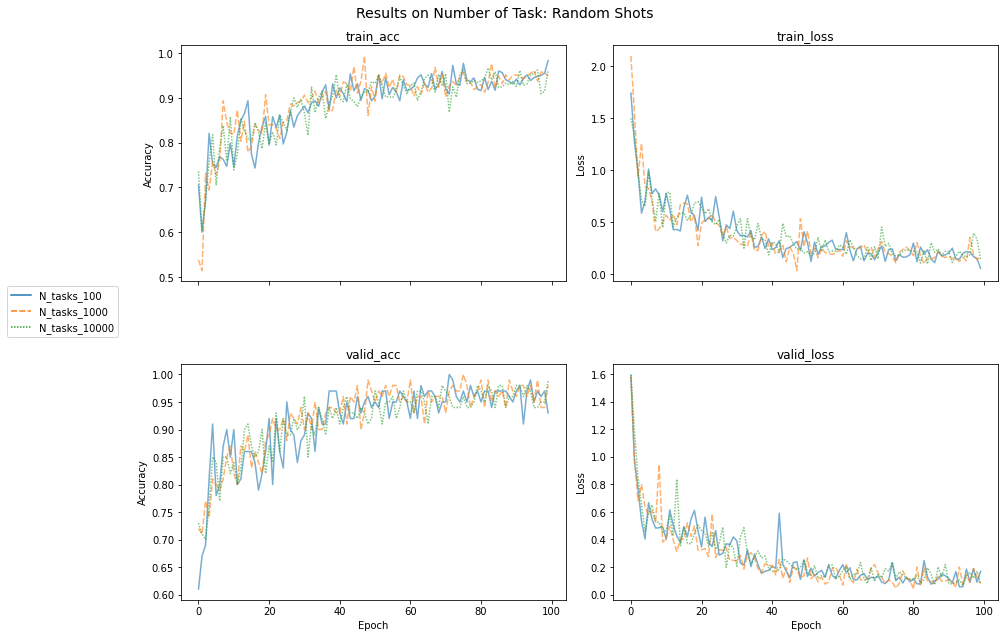

In [20]:
n_tasks_list = [100, 1000, 10000]
results = load_exp_results(file_path='result_random_tasks.pickle') 

fig, axes = plt.subplots(2, 2, figsize=(14, 9), sharex=True, sharey=False)

for i, title in enumerate(['train_acc', 'train_loss', 'valid_acc', 'valid_loss']):
    ax = axes.flatten()[i]
    df = pd.DataFrame(list(zip(*[results[t][i] for t in n_tasks_list])), columns=list(map(lambda x: f'N_tasks_{x}', n_tasks_list)))
    legend = 'auto' if i == 0 else False
    sns.lineplot(data=df, alpha=0.6, legend=legend, ax=ax)
    ax.set_title(f'{title}', size=12)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss' if 'loss' in title else 'Accuracy')
    if i == 0:
        ax.legend(bbox_to_anchor=(-0.15, 0.0))

fig.suptitle('Results on Number of Task: Random Shots', fontsize=14)
plt.tight_layout()
plt.show()
fig.savefig('3.png')